In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from loguru import logger
import warnings
import re
import emoji

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.columns
# df.info()

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

In [4]:
# Count the amount of messages for top 15 authors.
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [5]:
topk_authors = list(topk.index)
# topk_authors

In [6]:
# Define the authors to select
selected_authors = ["intense-toad", "vivid-rhinoceros", "zany-trout"]

# Define the rename map
rename_map = {
    "intense-toad": "Voorzitter",
    "vivid-rhinoceros": "Attent bewoner",
    "zany-trout": "Klusjesman bewoner"
}

# Filter the original df for selected authors
df_selected = df[df['author'].isin(selected_authors)].copy()

# Apply the rename mapping
df_selected['author'] = df_selected['author'].map(rename_map)

# Verify
# df_selected.head()



In [7]:
# Extract year
df_selected['year'] = df_selected['timestamp'].dt.year

# Count messages per author per year
df_counts = (
    df_selected.groupby(['author', 'year'])
    .size()
    .reset_index(name='message_count')
)

# Get min and max year in the data
min_year, max_year = df_counts['year'].min(), df_counts['year'].max()

def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

df_selected['emoji_count'] = df_selected['message'].apply(count_emojis)


# Create a 'year_month' column
df_selected['year_month'] = df_selected['timestamp'].dt.to_period('M').dt.to_timestamp()

# Aggregate counts per author per month
monthly_counts = df_selected.groupby(['year_month', 'author']).size().reset_index(name='message_count')

# Create a 'year_quarter' column
df_selected['year_quarter'] = df_selected['timestamp'].dt.to_period('Q').dt.start_time

# Aggregate counts per author per quarter
quarterly_counts = df_selected.groupby(['year_quarter', 'author']).size().reset_index(name='message_count')


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_10974/1253462598.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_selected['year_month'] = df_selected['timestamp'].dt.to_period('M').dt.to_timestamp()
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_10974/1253462598.py:27: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_selected['year_quarter'] = df_selected['timestamp'].dt.to_period('Q').dt.start_time


In [8]:
# Ensure emoji_count exists
if 'emoji_count' not in df_selected.columns:
    import emoji
    def count_emojis(text):
        return len([c for c in text if c in emoji.EMOJI_DATA])
    df_selected['emoji_count'] = df_selected['message'].apply(count_emojis)

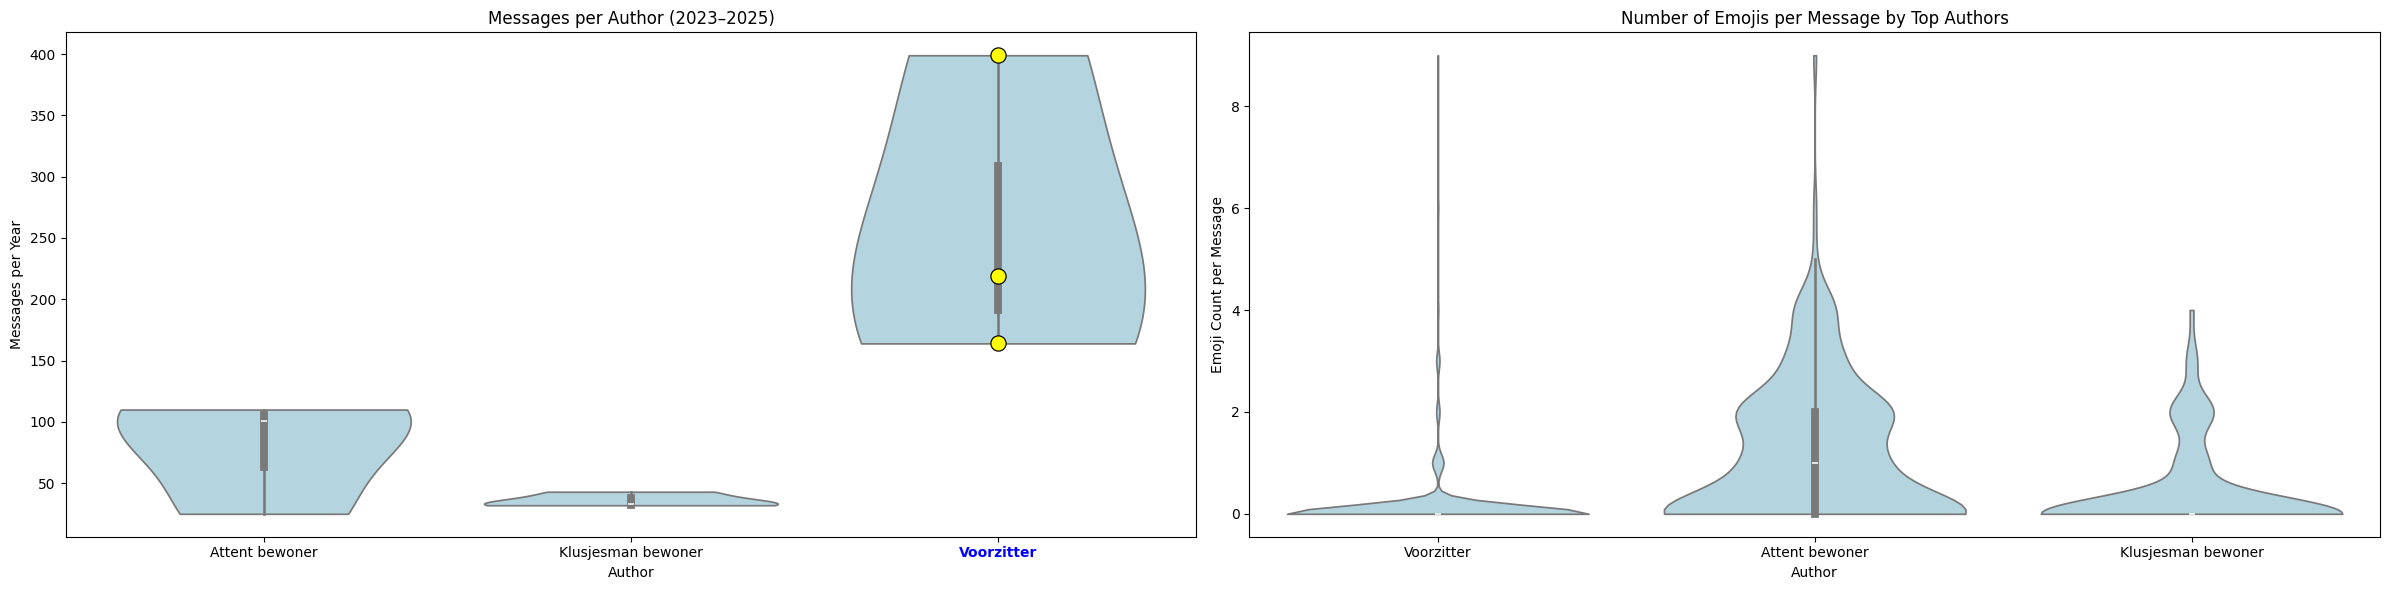

In [9]:
# Create subplots with 2 plots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 6))  # 2 plots

# === First plot: message_count distribution ===
sns.violinplot(
    ax=axes[0],
    data=df_counts,
    x='author',
    y='message_count',
    inner='box',
    cut=0,
    palette=["#ADD8E6"] * len(df_counts['author'].unique())
)
# Highlight max authors per year
max_per_year = df_counts.loc[df_counts.groupby('year')['message_count'].idxmax()]
sns.scatterplot(
    ax=axes[0],
    data=max_per_year,
    x='author',
    y='message_count',
    color='yellow',
    edgecolor='black',
    s=120,
    marker='o',
    zorder=10
)
axes[0].set_title(f"Messages per Author ({min_year}–{max_year})")
axes[0].set_ylabel('Messages per Year')
axes[0].set_xlabel('Author')
# Bold and blue the author with most total messages
most_messages_author = df_counts.groupby('author')['message_count'].sum().idxmax()
for tick in axes[0].get_xticklabels():
    if tick.get_text() == most_messages_author:
        tick.set_fontweight('bold')
        tick.set_color('blue')

# === Second plot (was third originally): emoji count distribution ===
sns.violinplot(
    ax=axes[1],
    data=df_selected,
    x='author',
    y='emoji_count',
    inner='box',
    cut=0,
    palette=["#ADD8E6"] * len(selected_authors)
)
axes[1].set_title("Number of Emojis per Message by Top Authors")
axes[1].set_ylabel("Emoji Count per Message")
axes[1].set_xlabel("Author")

plt.tight_layout()
plt.show()


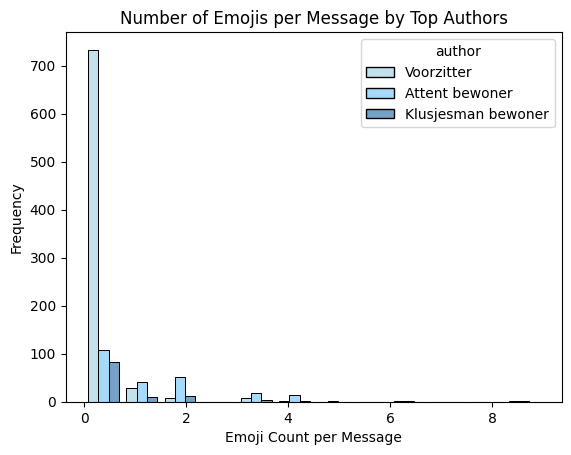

In [10]:
sns.histplot(
    data=df_selected,
    x='emoji_count',
    hue='author',
    multiple='dodge',   # side-by-side bars
    shrink=0.8,
    palette=["#ADD8E6", "#87CEFA", "#4682B4"]
)
plt.title("Number of Emojis per Message by Top Authors")
plt.xlabel("Emoji Count per Message")
plt.ylabel("Frequency")
plt.show()


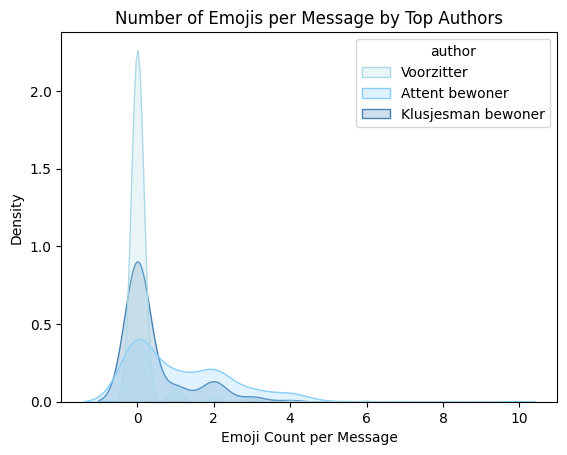

In [11]:
sns.kdeplot(
    data=df_selected,
    x='emoji_count',
    hue='author',
    fill=True,
    common_norm=False,
    palette=["#ADD8E6", "#87CEFA", "#4682B4"]
)
plt.title("Number of Emojis per Message by Top Authors")
plt.xlabel("Emoji Count per Message")
plt.ylabel("Density")
plt.show()


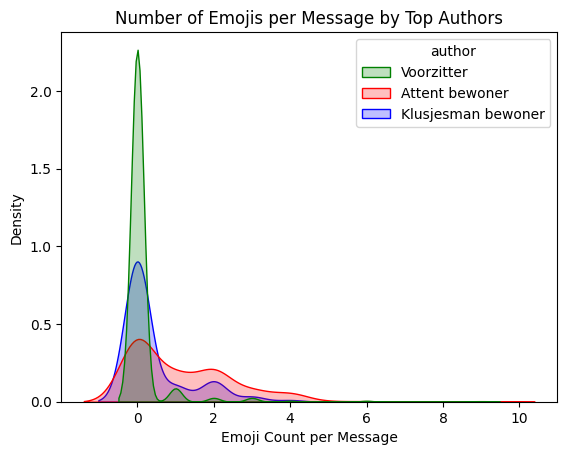

In [18]:
"""
X-axis (emoji_count): The number of emojis in each message.
Y-axis (Density): How likely a message is to have that number of emojis. This is a smoothed version of a histogram
Attent bewoner: tends to use more emojis in consistent way
Differences between authors in communication style
"""
sns.kdeplot(
    data=df_selected,
    x='emoji_count',
    hue='author',
    fill=True,
    common_norm=False,
    palette=["green", "red", "blue"]
)
plt.title("Number of Emojis per Message by Top Authors")
plt.xlabel("Emoji Count per Message")
plt.ylabel("Density")
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_10974/867214361.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  klusjesman_df['year_quarter'] = klusjesman_df['timestamp'].dt.to_period('Q')


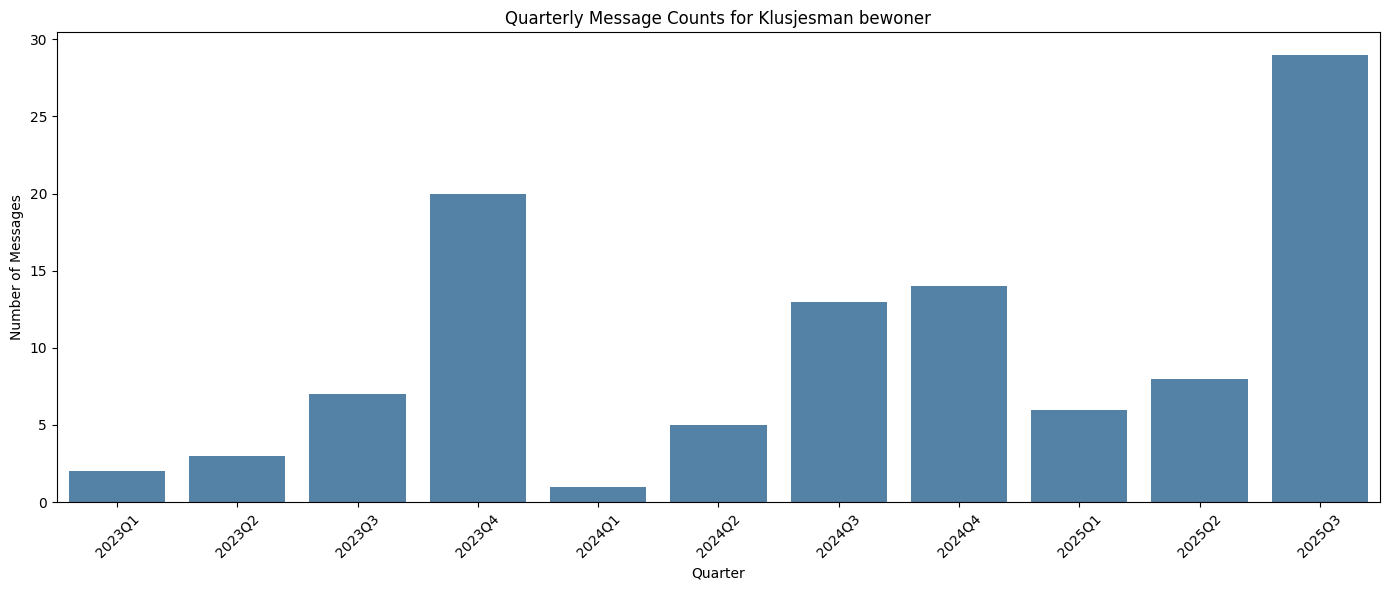

In [12]:
# %%
# Filter for "Klusjesman bewoner"
klusjesman_df = df_selected[df_selected['author'] == "Klusjesman bewoner"].copy()

# Create a 'year_quarter' column for grouping
klusjesman_df['year_quarter'] = klusjesman_df['timestamp'].dt.to_period('Q')

# Aggregate message counts per quarter
quarterly_counts = klusjesman_df.groupby('year_quarter').size().reset_index(name='message_count')

# %%
# Plot the histogram/barplot
plt.figure(figsize=(14,6))
sns.barplot(
    data=quarterly_counts,
    x='year_quarter',
    y='message_count',
    color='steelblue'
)
plt.xticks(rotation=45)
plt.title("Quarterly Message Counts for Klusjesman bewoner")
plt.xlabel("Quarter")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Klusjesman bewoner
klusjesman_df = df_selected[df_selected['author'] == "Klusjesman bewoner"].copy()
klusjesman_df['timestamp'] = pd.to_datetime(klusjesman_df['timestamp'])

# Convert timestamps to numeric values for KDE
timestamps_num = mdates.date2num(klusjesman_df['timestamp'])

# Plot KDE
plt.figure(figsize=(14,6))
sns.kdeplot(
    x=timestamps_num,
    color='orange',
    linewidth=2,
    fill=True
)

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.title("KDE of Messages for Klusjesman bewoner")
plt.xlabel("Date")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
